In [1]:
import os
os.chdir(os.path.abspath("./.."))

import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorboard
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

import shap
import lime

def data_zero_masking(data):
    data[np.isnan(data)] = 0
    return data

In [17]:
%load_ext tensorboard
%tensorboard --logdir ./models/Conv1D/logs/{log_latest}

In [2]:
logs = os.listdir('./models/Conv1D/logs/')
log_ts = [datetime.datetime.strptime(log_ts[:15], "%Y%m%d-%H%M%S") for log_ts in logs]
log_latest = logs[log_ts.index(max(log_ts))]

# %load_ext tensorboard
# %tensorboard --logdir ./models/Conv1D/logs/{log_latest}

model = keras.models.load_model(f"models/Conv1D/models/{log_latest}")

2021-12-16 19:12:00.392672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:12:00.396780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:12:00.396962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:12:00.397509: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
ds_pos = tf.data.experimental.load('processed/patient_data/dx_pred_0_12_3src/tf_dataset/dataset_train_pos')
ds_neg = tf.data.experimental.load('processed/patient_data/dx_pred_0_12_3src/tf_dataset/dataset_train_neg')

X = ds_pos.take(500).concatenate(ds_neg.take(500))
X = list(X.as_numpy_iterator())

Xt = [x[0]['time_series_inputs'] for x in X]
Xs = [x[0]['static_inputs'] for x in X]
Xt = np.array(Xt)
Xs = np.array(Xs)

In [4]:
data_folder = 'processed/patient_data/dx_pred_0_12_3src'

info_test, data_test, label_test = np.load(os.path.join(data_folder, 'test_data.npy'), allow_pickle=True)
info_test = data_zero_masking(info_test)
data_test = data_zero_masking(data_test)[:,:,1:]

N_val = int(len(label_test)/2)
# dataset_val = ({'static_inputs': info_test[:N_val], 'time_series_inputs': data_test[:N_val]}, label_test[:N_val])
dataset_test = ({'static_inputs': info_test[N_val:], 'time_series_inputs': data_test[N_val:]}, label_test[N_val:])

idx_pos_test = np.where(np.array(dataset_test[1])==1)
idx_neg_test = np.where(np.array(dataset_test[1])==0)
Xt_test = np.array(dataset_test[0]['time_series_inputs'])[idx_pos_test][:5]
Xt_test = np.vstack((Xt_test, np.array(dataset_test[0]['time_series_inputs'])[idx_neg_test][:5]))
Xs_test = np.array(dataset_test[0]['static_inputs'])[idx_pos_test][:5]
Xs_test = np.vstack((Xs_test, np.array(dataset_test[0]['static_inputs'])[idx_neg_test][:5]))

In [5]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.DeepExplainer(model, [Xs, Xt])
shap_values = explainer.shap_values([Xs_test[:10], Xt_test[:10]])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2021-12-16 19:12:02.442130: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2021-12-16 19:12:02.733524: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-12-16 19:12:02.734336: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2021-12-16 19:12:02.734343: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2021-12-16 19:12:02.734380: W tensorflow/str

In [6]:
shap_values[0][1].shape

(10, 144, 25)

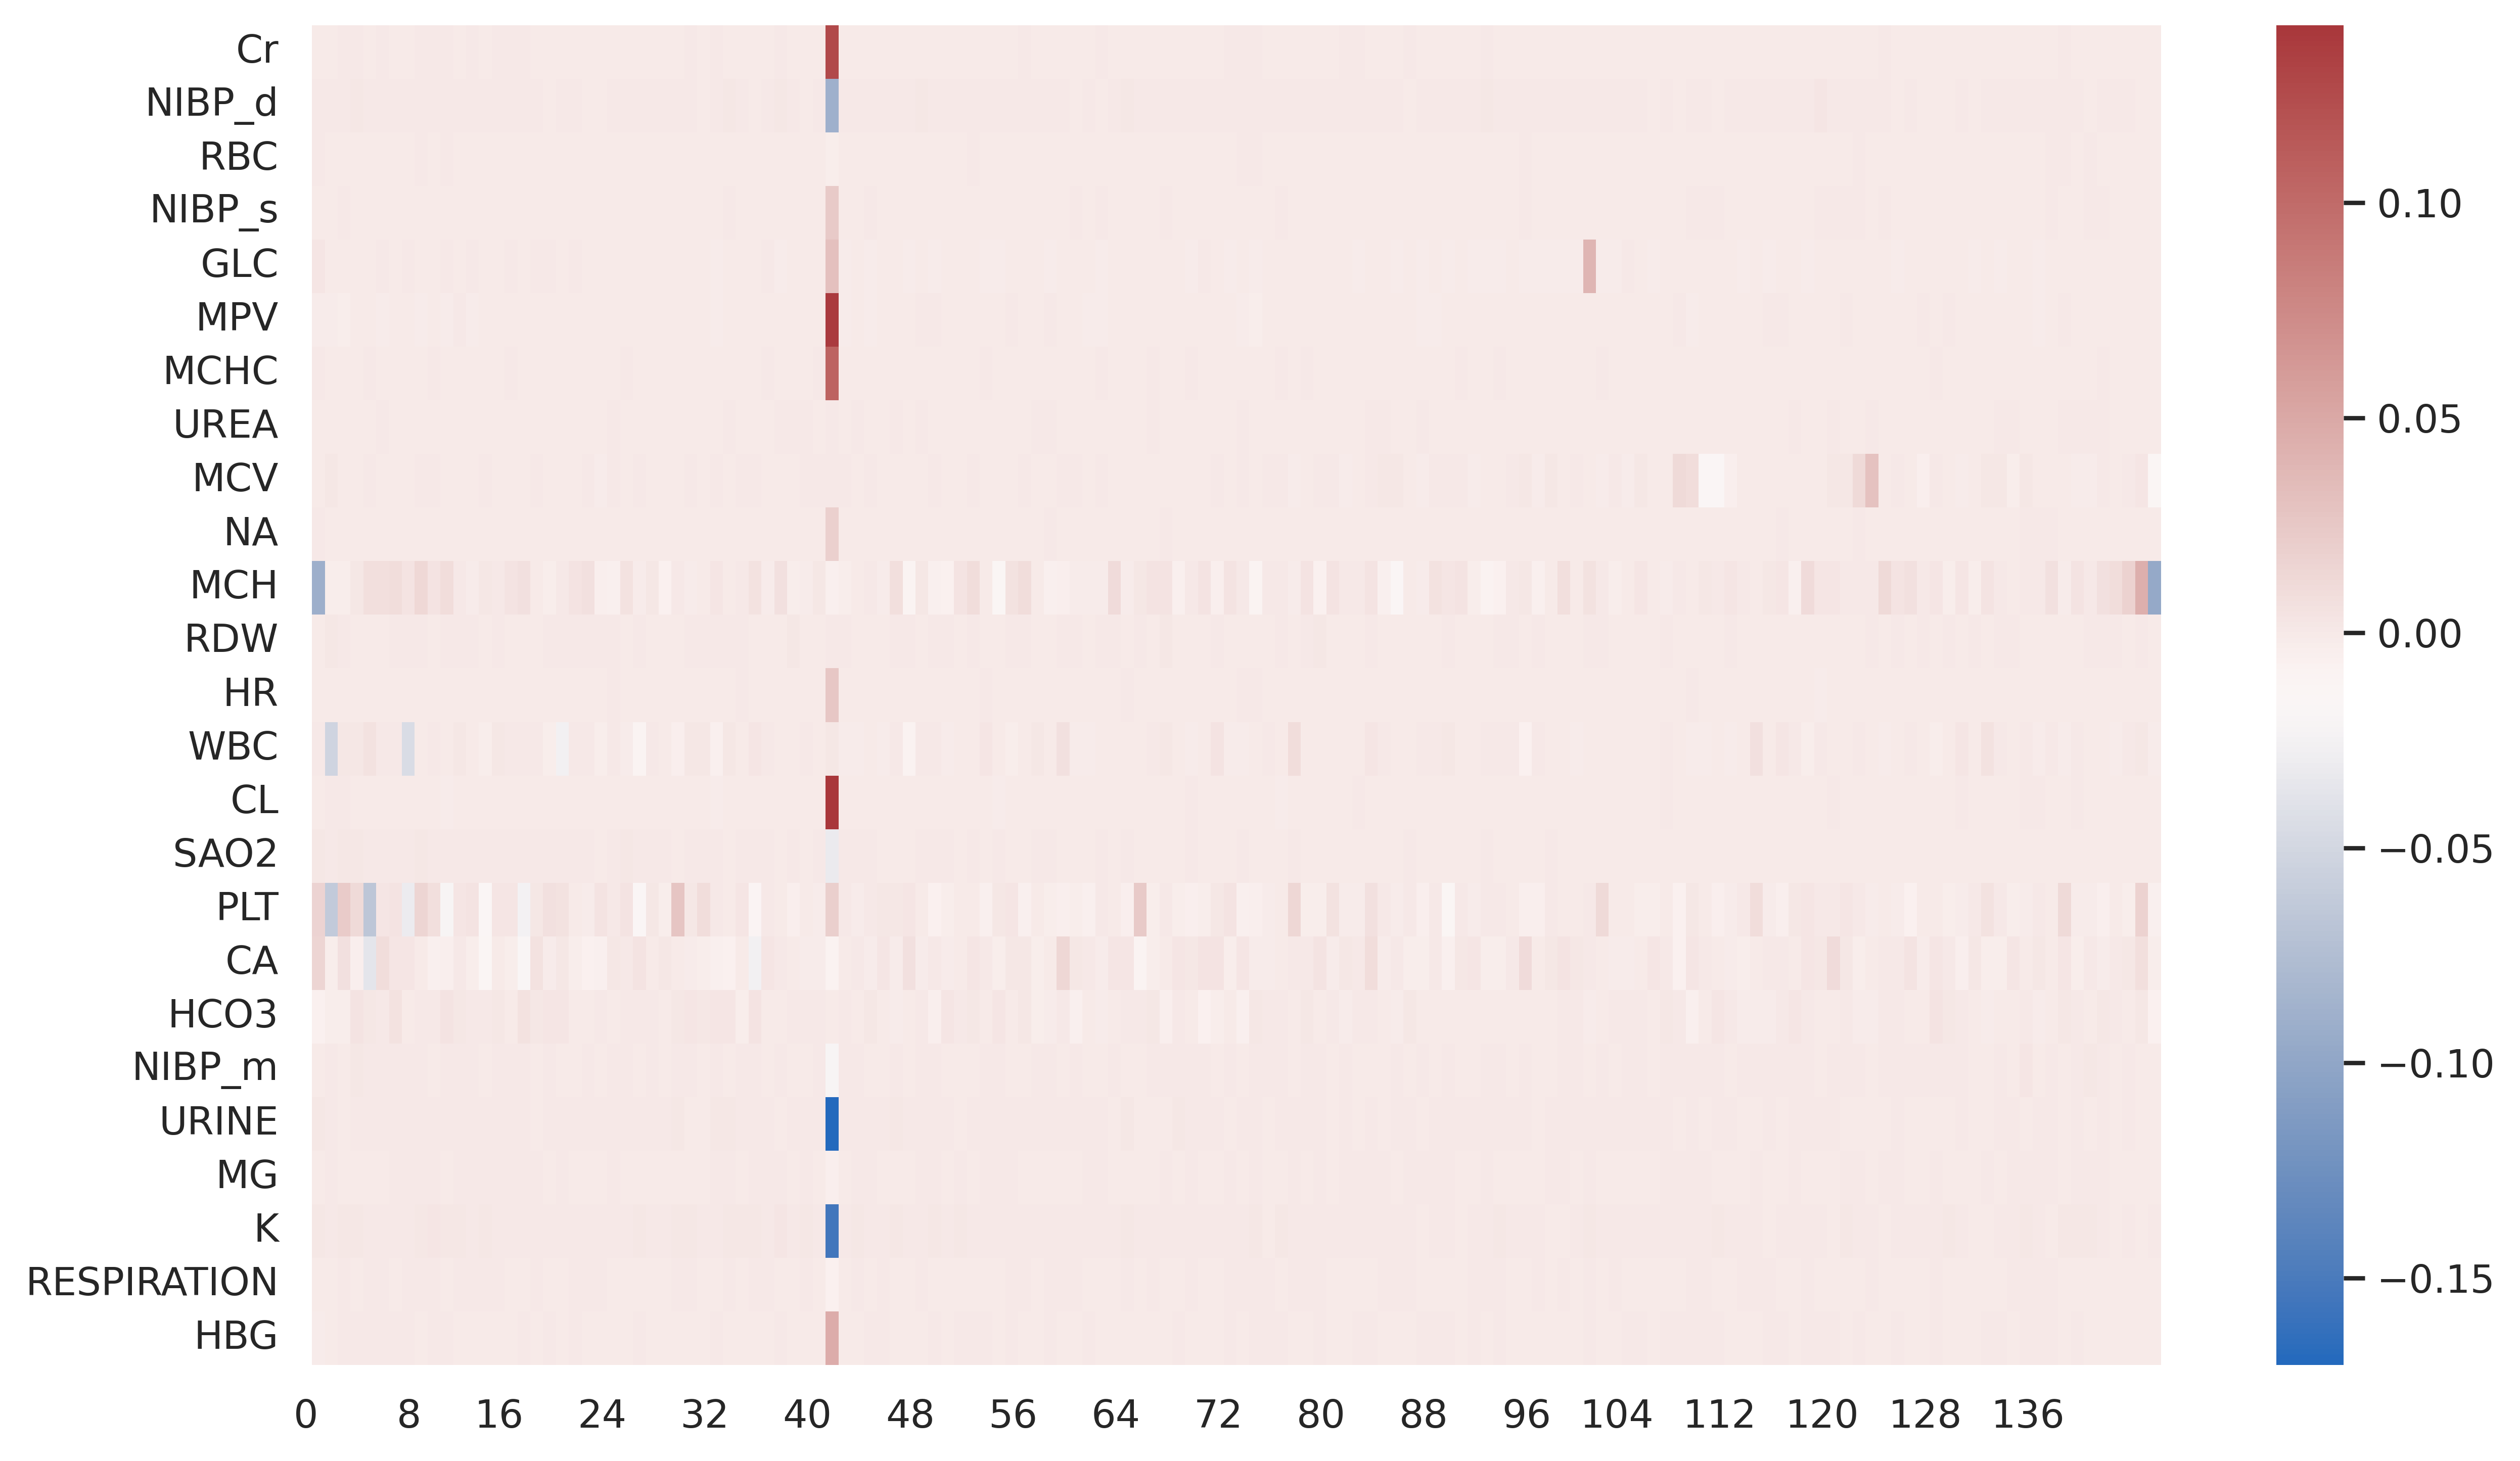

In [15]:
import seaborn as sns; sns.set_theme()

static_names = ['Gender', 'Age', 'Weight', 'Height']

feature_names = [
    'Cr', 'NIBP_d','RBC', 'NIBP_s', 'GLC', 'MPV', 'MCHC', 
    'UREA', 'MCV', 'NA', 'MCH', 'RDW', 'HR', 'WBC', 'CL',
    'SAO2', 'PLT', 'CA', 'HCO3', 'NIBP_m', 'URINE', 'MG', 'K', 'RESPIRATION', 'HBG'
]

xlabels = [str(xlabel) for xlabel in np.arange(0, 144)]

feat_scores = shap_values[0][1][1,:,:].T

fig, ax = plt.subplots(figsize=(10,6), dpi=500)
fig.tight_layout()
ax = sns.heatmap(feat_scores, yticklabels=feature_names, xticklabels=xlabels, 
                cmap='vlag')

plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor");
plt.locator_params(axis='x', nbins=18)

TypeError: only integer scalar arrays can be converted to a scalar index

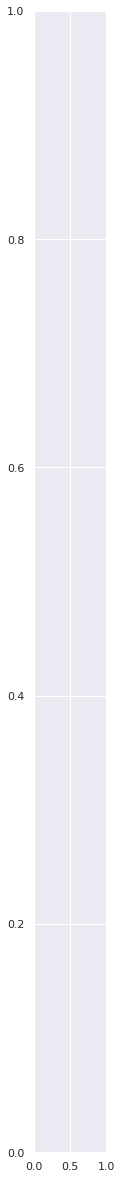

In [29]:
shap.initjs()
shap.summary_plot(
    shap_values[0][1], 
    Xt_test,
    feature_names=feature_names,
    max_display=50,
    plot_type='bar')

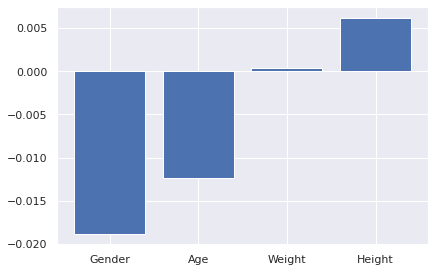

In [9]:
static_scores = shap_values[0][0][1,:]

fig, ax = plt.subplots()
fig.tight_layout()
ax.bar(np.arange(4), static_scores)
ax.set_xticks(np.arange(4), labels=static_names)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

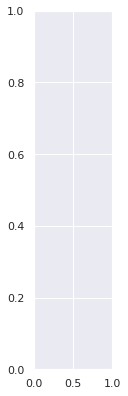

In [21]:
shap.summary_plot(shap_values[0][1], Xt_test[:10])

In [25]:
shap_values[0][1].shape, Xt_test[:10].shape

((10, 144, 25), (10, 144, 25))

In [23]:
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         [Xs_test[1], Xt_test[1]], 
         model.predict
)


AttributeError: 'list' object has no attribute 'shape'

NameError: name 'explanation' is not defined

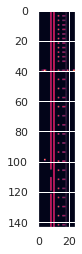

In [24]:
plt.imshow(Xt_test[1])

image, mask = explanation.get_image_and_mask(
         model.predict(
              x_train[10].reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))